# OT-GAN

## Importation des modules

In [1]:
# Packages de base
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
from tqdm.notebook import tqdm
# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers

# Transport
#import ot

# Graphiques

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Importation des données

La base de données MNIST est composée de respectivement 60000 et 10000 images dans sa partie "Train" et sa partie "Test". Chaque image représente un chiffre et est composée de 28 x 28 pixels.

### Base d'entrainement & Base de Test

## Paramètres

## Création du générateur

In [4]:
class cRelu(layers.Layer):

    def __init__(self, **kwargs):
        super(cRelu, self).__init__(**kwargs)

    def build(self, input_shape):
        super(cRelu, self).build(input_shape)

    def call(self, x):
        return tf.nn.crelu(x)

    def compute_output_shape(self, input_shape):
        """
        All axis of output_shape, except the last one,
        coincide with the input shape.
        The last one is twice the size of the corresponding input 
        as it's the axis along which the two relu get concatenated.
        """
        return (*input_shape[:-1], input_shape[-1]*2)

In [5]:
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation

class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config


In [6]:
def CreationGenerateur():
    
    # Initialisation
    model = tf.keras.Sequential()
    
    # Linear Reshape 100 -> 256x7x7
    model.add(layers.Dense(256*7*7, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    # 256x7x7 -> 128x7x7
    # stride = 1, activation = GLU
    model.add(FullGatedConv2D(128, kernel_size=(5, 5), 
                              strides=(1, 1),
                              activation = 'linear',
                              padding='same',
                              use_bias=False))
    print(model.output_shape)

    # 128x7x7 -> 64x14x14
    model.add(layers.UpSampling2D())
    model.add(FullGatedConv2D(64, kernel_size=(5, 5), strides=(1, 1), 
                              activation = 'linear',
                              padding='same',
                              use_bias=False))
    print(model.output_shape)

    model.add(layers.UpSampling2D())
    model.add(FullGatedConv2D(64, kernel_size=(5, 5), 
                              strides=(1, 1), 
                              activation = 'linear',
                              padding='same',
                              use_bias=False))
    print(model.output_shape)

    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5),
                                     strides=(1, 1), 
                                     activation = 'tanh', 
                                     padding='same', 
                                     use_bias=False))
    print(model.output_shape)

    return model

    #model.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    #model.add(layers.Conv2D(,kernel_size=(5,5)), padding=)

### Initialisation et exemple

Le bruit en input du générateur est initialisé par un vecteur aléatoire de taille 100 et de loi uniforme sur [-1,1].

## Création du discriminant

In [7]:
def CreationDiscriminateur():
    
    # Initialisation
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(50, kernel_size=(5, 5),
                            strides=(1, 1), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(cRelu())
    print(model.output_shape)

    model.add(layers.Conv2D(100,kernel_size= (5, 5),
                            strides=(2, 2), padding='same'))
    model.add(cRelu())
    print(model.output_shape)

    model.add(layers.Conv2D(100,kernel_size= (5, 5),
                            strides=(2, 2), padding='same'))
    model.add(cRelu())
    print(model.output_shape)

    model.add(layers.Flatten())
    print(model.output_shape)
    
    return model



### Initialisation
On initialise les poids (arbitrairement) selon une loi Normale centrée d'écart-type 0.02

## Fonction de perte

## Implémentation de Sinkhorn

Afin de pouvoir utiliser la différentiation automatique pour calculer le gradient de la perte, nous allons implémenter l'algorithme Sinkhorn en utilisant Tensorflow.

In [8]:
def Sinkhorn(M, m_size, reg, numItermax=1000, stopThr=1e-9):
    # we assume that no distances are null except those of the diagonal of distances

    a = tf.expand_dims(tf.ones(shape=(m_size[0],)) / m_size[0], axis=1)  # (na, 1)
    b = tf.expand_dims(tf.ones(shape=(m_size[1],)) / m_size[1], axis=1)  # (nb, 1)

    # init data
    Nini = m_size[0]
    Nfin = m_size[1]

    u = tf.expand_dims(tf.ones(Nini) / Nini, axis=1)  # (na, 1)
    v = tf.expand_dims(tf.ones(Nfin) / Nfin, axis=1)  # (nb, 1)

    K = tf.exp(-M / reg)  # (na, nb)

    Kp = (1.0 / a) * K  # (na, 1) * (na, nb) = (na, nb)

    cpt = tf.constant(0)
    err = tf.constant(1.0)

    c = lambda cpt, u, v, err: tf.logical_and(cpt < numItermax, err > stopThr)

    def err_f1():
        # we can speed up the process by checking for the error only all the 10th iterations
        transp = u * (K * tf.squeeze(v))  # (na, 1) * ((na, nb) * (nb,)) = (na, nb)
        err_ = tf.pow(tf.norm(tf.reduce_sum(transp) - b, ord=1), 2)  # (,)
        return err_

    def err_f2():
        return err

    def loop_func(cpt, u, v, err):
        KtransposeU = tf.matmul(tf.transpose(K, (1, 0)), u)  # (nb, na) x (na, 1) = (nb, 1)
        v = tf.divide(b, KtransposeU)  # (nb, 1)
        u = 1.0 / tf.matmul(Kp, v)  # (na, 1)

        err = tf.cond(tf.equal(cpt % 10, 0), err_f1, err_f2)

        cpt = tf.add(cpt, 1)
        return cpt, u, v, err

    _, u, v, _ = tf.while_loop(c, loop_func, loop_vars=[cpt, u, v, err])

    result = tf.reduce_sum(u * K * tf.reshape(v, (1, -1)) * M)

    return result


In [9]:
def TransCost(X,Y):

  CX = tf.tile(tf.expand_dims(X, axis=1), [1, Y.shape[0], 1])
  CY = tf.tile(tf.expand_dims(Y, axis=0), [X.shape[0], 1, 1])
  CC = tf.add(tf.ones((X.shape[0],Y.shape[0])),tf.keras.losses.CosineSimilarity(axis=2)(CX,CY))
  return CC

In [10]:
def WassersteinD(X,Y,Penalite):
  CX = tf.tile(tf.expand_dims(X, axis=1), [1, Y.shape[0], 1])
  CY = tf.tile(tf.expand_dims(Y, axis=0), [X.shape[0], 1, 1])
  CC = tf.keras.losses.cosine_similarity(CX,CY)
  CSize = CC.shape
  W = Sinkhorn(CC, CSize, Penalite, numItermax=1000, stopThr=1e-9)
  return W

In [11]:
def Loss(X1,X2,Y1,Y2,Penalite):
  
  I1 = tf.add(WassersteinD(X1,Y1,Penalite),WassersteinD(X1,Y2,Penalite))
  I1 = tf.add(I1, WassersteinD(X2,Y1,Penalite))
  I1 = tf.add(I1, WassersteinD(X2,Y2,Penalite))
  I1 = tf.subtract(I1, tf.multiply(2.,WassersteinD(X1,X2,Penalite)))
  L = tf.subtract(I1, tf.multiply(2.,WassersteinD(Y1,Y2,Penalite)))

  return L

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
generator = CreationGenerateur()
discriminator = CreationDiscriminateur()

(None, 7, 7, 128)
(None, 14, 14, 64)
(None, 28, 28, 64)
(None, 28, 28, 1)
(None, 28, 28, 100)
(None, 14, 14, 200)
(None, 7, 7, 200)
(None, 9800)


In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Optimizers

## Entrainement

In [15]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images[train_labels == 8]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
BUFFER_SIZE = 1000
BATCH_SIZE = 50
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(2*BATCH_SIZE)



In [16]:
i = 0
for _ in train_dataset:
    i+=1
i

59

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images): #image de taille [2*BATCH_SIZE]
    temps1 = time.time()
    noise1 = tf.random.uniform([BATCH_SIZE, noise_dim],-1,1)
    noise2 = tf.random.uniform([BATCH_SIZE, noise_dim],-1,1)


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images_1 = generator(noise1, training=True)
      generated_images_2 = generator(noise2, training=True)
      temps2 = time.time()

      real_output_1 = discriminator(images[:BATCH_SIZE], training=True)
      real_output_2 = discriminator(images[BATCH_SIZE:], training=True)
      temps3 = time.time()
      fake_output_1 = discriminator(generated_images_1, training=True)
      fake_output_2 = discriminator(generated_images_2, training=True)

      temps4 = time.time()
      loss = Loss(real_output_1, real_output_2,
                  fake_output_1, fake_output_2,
                  Penalite = 1/100)
      
    temps5 = time.time()

    gradients_of_generator = gen_tape.gradient(loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(loss, discriminator.trainable_variables)
    temps6 = time.time()

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    temps7 = time.time()
    print(temps2-temps1,temps3-temps2,temps4-temps3,temps5-temps4,temps6-temps5,temps7-temps6)

In [18]:
def train(dataset, epochs):
  for epoch in tqdm(range(epochs)):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [19]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [47]:
def TransCost(X,Y):
    n = X.shape[0]
    CC =tf.zeros([n,n])
    for i in tf.range(n):
        for j in tf.range(n):
            CC[i,j] = tf.keras.losses.cosine_similarity(X[i],Y[j])
    return CC

In [50]:
n=100
X = tf.random.normal([n,100])
Y = tf.random.normal([n,100])
tf.concat(X,0)==X

<tf.Tensor: shape=(100, 100), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

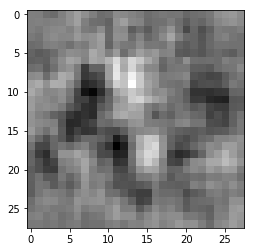

In [40]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
print(1)